# Elo Merchant Category Recommendation - LynxKite preprocessor
In this tutorial you can solve the [Elo Mechant Category Recommendation](https://www.kaggle.com/c/elo-merchant-category-recommendation) contest with the help of LynxKite. Unfortunately LynxKite does not yet support some of the data preprocessing, thus it needs to be done in Python.

First download the input files from [here](https://www.kaggle.com/c/elo-merchant-category-recommendation/data), unzip them and copy the extracted files to the `input` folder. These files are

- **train.csv**,  **test.csv**: list of `card_ids` that can be used for training and prediction
- **historical_transactions.csv**: contains up to 3 months' worth of transactions for every card at any of the provided `merchant_ids`
- **new_merchant_transactions.csv**: contains the transactions at new merchants (`merchant_ids` that this particular `card_id` 
has not yet visited) over a period of two months
- **merchants.csv**: contains aggregate information for each `merchant_id` represented in the data set

In [1]:
import gc
import math
import warnings
import datetime
import numpy as np
import pandas as pd
from scipy.stats import iqr
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Starting memory usage: {:5.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Reduced memory usage: {:5.2f} MB ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [3]:
def create_date_features(df, source_column, preposition):
    df[preposition + '_year'] = df[source_column].dt.year
    df[preposition + '_month'] = df[source_column].dt.month
    df[preposition + '_day'] = df[source_column].dt.day
    df[preposition + '_hour'] = df[source_column].dt.hour
    df[preposition + '_weekofyear'] = df[source_column].dt.weekofyear
    df[preposition + '_dayofweek'] = df[source_column].dt.dayofweek
    df[preposition + '_quarter'] = df[source_column].dt.quarter
    
    return df

## Input data preparation
### Train & test data

In [4]:
df_train = pd.read_csv("input/train.csv", parse_dates=["first_active_month"], index_col="card_id")
df_train = reduce_mem_usage(df_train)
print("{:,} observations and {} features in train set.".format(df_train.shape[0], df_train.shape[1]))

Starting memory usage:  9.24 MB
Reduced memory usage:  4.04 MB (56.2% reduction)
201,917 observations and 5 features in train set.


In [5]:
df_test = pd.read_csv("input/test.csv", parse_dates=["first_active_month"], index_col="card_id")
df_test = reduce_mem_usage(df_test)
print("{:,} observations and {} features in test set.".format(df_test.shape[0], df_test.shape[1]))

Starting memory usage:  4.72 MB
Reduced memory usage:  2.24 MB (52.5% reduction)
123,623 observations and 4 features in test set.


In [6]:
df_train[:3]

,first_active_month,feature_1,feature_2,feature_3,target
card_id,,,,,
C_ID_92a2005557,2017-06-01,5,2,1,-0.820312
C_ID_3d0044924f,2017-01-01,4,1,0,0.392822
C_ID_d639edf6cd,2016-08-01,2,2,0,0.687988


In [7]:
df_test[:3]

,first_active_month,feature_1,feature_2,feature_3
card_id,,,,
C_ID_0ab67a22ab,2017-04-01,3,3,1
C_ID_130fd0cbdd,2017-01-01,2,3,0
C_ID_b709037bc5,2017-08-01,5,1,1


In [8]:
q1_tr = int(df_train['target'].count()/4)
q3_tr = int(3*df_train['target'].count()/4)

df_train.sort_values(by='target', inplace=True, na_position='last')

print('Range of the target in the training set: {} - {}'.format(df_train['target'].min(), df_train['target'].max()))
print('Interquartile range of target in the training set: {} - {}'.format(df_train['target'].iloc[q1_tr], df_train['target'].iloc[q3_tr]))

Range of the target in the training set: -33.21875 - 17.96875
Interquartile range of target in the training set: -0.88330078125 - 0.765625


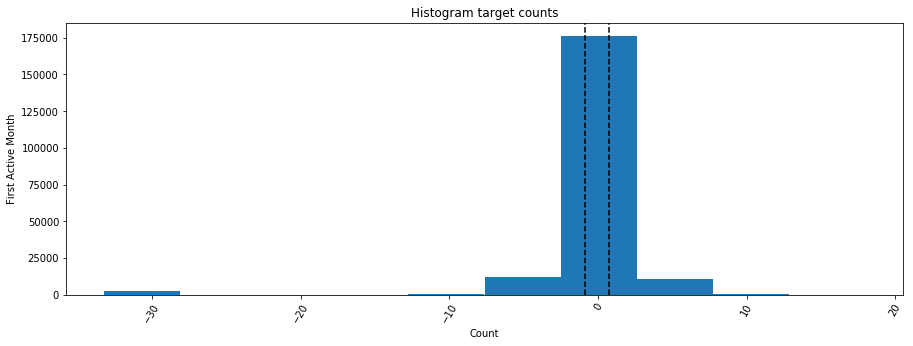

In [9]:
plt.figure(figsize=(15, 5))
plt.hist(df_train['target'].values)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.xticks(rotation=60)
plt.ylabel('First Active Month')
plt.axvline(df_train['target'].iloc[q1_tr], color="k", linestyle="--")
plt.axvline(df_train['target'].iloc[q3_tr], color="k", linestyle="--")
plt.show()

In [10]:
print('According to Rice\'s rule, the number of bins is {:.0f} (for the whole set)'.format(math.sqrt(df_train.shape[0])*2))
print('According to Rice\'s rule, the number of bins is {:.0f} (without the outliers)'.format(math.sqrt(df_train[df_train['target'] > -30].shape[0])*2))

According to Rice's rule, the number of bins is 899 (for the whole set)
According to Rice's rule, the number of bins is 894 (without the outliers)


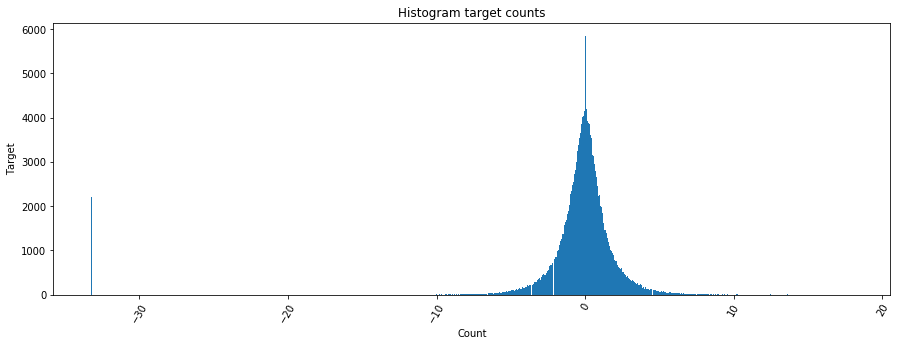

In [11]:
plt.figure(figsize=(15, 5))
plt.hist(df_train['target'].values, bins=899)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.xticks(rotation=60)
plt.ylabel('Target')
plt.show()

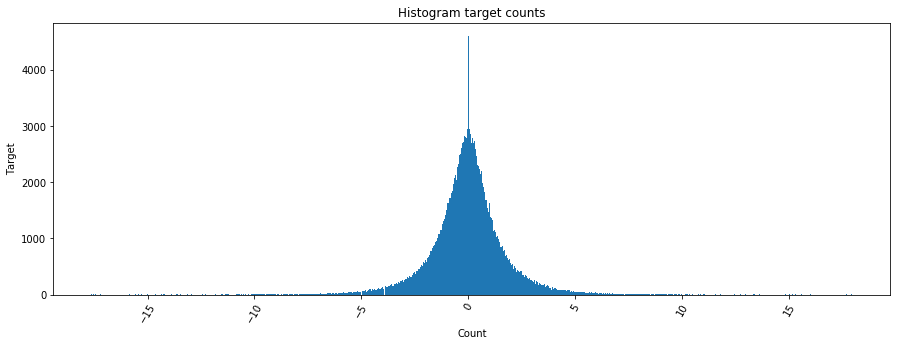

In [12]:
plt.figure(figsize=(15, 5))
plt.hist(df_train[df_train['target'] > -30]['target'].values, bins=894)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.xticks(rotation=60)
plt.ylabel('Target')
plt.show()

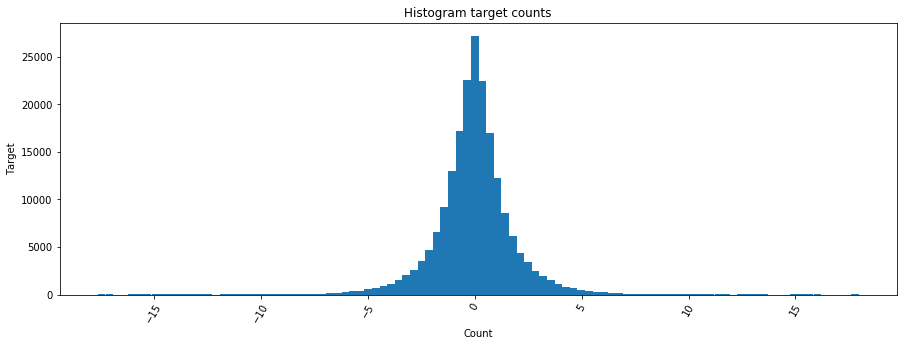

In [13]:
plt.figure(figsize=(15, 5))
plt.hist(df_train[df_train['target'] > -30]['target'].values, bins=100)
plt.title('Histogram target counts')
plt.xlabel('Count')
plt.xticks(rotation=60)
plt.ylabel('Target')
plt.show()

In [14]:
range = math.fabs(df_train[df_train['target'] > -30]['target'].min()) + df_train[df_train['target'] > -30]['target'].max()
print('The range of the training set without the outliers is {}'.format(range))

The range of the training set without the outliers is 35.578125


In [15]:
print('Minimum value without outliers: {}, width of bin: {}'.format(df_train[df_train['target'] > -30]['target'].min(), range/100))

Minimum value without outliers: -17.609375, width of bin: 0.35578125


In [16]:
def create_bin(value, min_value, bin_width, cutoff_value=-20):
    return np.where(value > min_value, ((value - min_value)/bin_width).astype(int), 0)

In [17]:
min_value = df_train[df_train['target'] > -30]['target'].min()
bin_width = range/100

df_train['target_bin'] = create_bin(df_train['target'], min_value, bin_width)

In [18]:
df_train[:5]

,first_active_month,feature_1,feature_2,feature_3,target,target_bin
card_id,,,,,,
C_ID_26891f7d19,2017-06-01,3,2,1,-33.21875,0
C_ID_5813c755d9,2014-10-01,5,1,1,-33.21875,0
C_ID_213342324e,2015-08-01,3,3,1,-33.21875,0
C_ID_80d84a0c20,2014-06-01,3,3,1,-33.21875,0
C_ID_f54535212e,2016-12-01,4,3,0,-33.21875,0


In [19]:
train_first = df_train['first_active_month'].min()
train_last = df_train['first_active_month'].max()

print("The first_active_month attribute in the train set is ranging between {0}-{1:02}-{2:02} and {3}-{4:02}-{5:02}.".format(train_first.year, train_first.month, train_first.day, train_last.year, train_last.month, train_last.day))

The first_active_month attribute in the train set is ranging between 2011-11-01 and 2018-02-01.


In [20]:
test_first = df_test['first_active_month'].min()
test_last = df_test['first_active_month'].max()

print("The first_active_month attribute in the test set is ranging between {0}-{1:02}-{2:02} and {3}-{4:02}-{5:02}.".format(test_first.year, test_first.month, test_first.day, test_last.year, test_last.month, test_last.day))

The first_active_month attribute in the test set is ranging between 2011-11-01 and 2018-01-01.


In [21]:
df_train["year"] = df_train["first_active_month"].dt.year
df_train["month"] = df_train["first_active_month"].dt.month

In [22]:
df_test["year"] = df_test["first_active_month"].dt.year
df_test["month"] = df_test["first_active_month"].dt.month

In [ ]:
df_train.to_csv('input/train_parsed.csv')
df_test.to_csv('input/test_parsed.csv')

In [23]:
df_output = pd.concat([df_train[df_train['target'] > -30], df_test])

In [32]:
print('Size of training set without outliers: {:,}\nSize of test set: {:,}\nSize of training + test set: {:,}'.format(
    len(df_train[df_train['target'] > -30]),
    len(df_test),
    len(df_output)
))

Size of training set without outliers: 199,710
Size of test set: 123,623
Size of training + test set: 323,333


In [33]:
df_output.to_csv('input/train_test_wo_outliers.csv')

In [36]:
df_output[:3]

,feature_1,feature_2,feature_3,first_active_month,month,target,target_bin,year
card_id,,,,,,,,
C_ID_8d4331102a,3,2,1,2017-02-01,2.0,-17.609375,0.0,2017.0
C_ID_3f7ba15ec2,1,1,0,2017-06-01,6.0,-17.500000,0.0,2017.0
C_ID_9636eefa07,1,1,0,2017-03-01,3.0,-17.437500,0.0,2017.0


In [ ]:
df_train.loc['C_ID_a003725b5b']

In [41]:
df_test.loc['C_ID_a003725b5b']

first_active_month    2016-10-01 00:00:00
feature_1                               3
feature_2                               1
feature_3                               1
year                                 2016
month                                  10
Name: C_ID_a003725b5b, dtype: object

### Transactions

In [4]:
%%time
df_hist_trans = pd.read_csv("input/historical_transactions.csv", index_col='card_id')
df_hist_trans = reduce_mem_usage(df_hist_trans)
print('Number of historical transactions: {:,}'.format(len(df_hist_trans)))

Starting memory usage: 3109.54 MB
Reduced memory usage: 1749.11 MB (43.8% reduction)
Number of historical transactions: 29,112,361
CPU times: user 1min 2s, sys: 1min 1s, total: 2min 4s
Wall time: 2min 32s


In [ ]:
df_new_trans = pd.read_csv("input/new_merchant_transactions.csv", index_col='card_id')
df_new_trans = reduce_mem_usage(df_new_trans)
print('Number of new transactions: {:,}'.format(df_new_trans['card_id'].count()))

In [5]:
df_hist_trans['authorized_flag'] = df_hist_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_hist_trans['category_1'] = df_hist_trans['category_1'].map({'Y': 1, 'N': 0})

df_hist_trans['purchase_date'] = pd.to_datetime(df_hist_trans['purchase_date'])
df_hist_trans = create_date_features(df_hist_trans, 'purchase_date', 'purchase')

In [ ]:
df_new_trans['authorized_flag'] = df_new_trans['authorized_flag'].map({'Y': 1, 'N': 0})
df_new_trans['category_1'] = df_new_trans['category_1'].map({'Y': 1, 'N': 0})

df_new_trans['purchase_date'] = pd.to_datetime(df_new_trans['purchase_date'])
df_new_trans = create_date_features(df_new_trans, 'purchase_date', 'purchase')

In [6]:
df_hist_trans[:3]

,authorized_flag,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id,purchase_year,purchase_month,purchase_day,purchase_hour,purchase_weekofyear,purchase_dayofweek,purchase_quarter
card_id,,,,,,,,,,,,,,,,,,,,
C_ID_4e6213e9bc,1,88,0,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37,2017,6,25,15,25,6,2
C_ID_4e6213e9bc,1,88,0,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16,2017,7,15,12,28,5,3
C_ID_4e6213e9bc,1,88,0,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37,2017,8,9,22,32,2,3


In [ ]:
df_new_trans[:3]

The preprocessed training and test sets can now be saved to disk as CSV.

In [ ]:
cols = ('C_ID_3b297b98b2', 'C_ID_0dcb7bedcf', 'C_ID_4dcdeb27e4', 'C_ID_96bb9e0008', 'C_ID_c0b9cac086', 'C_ID_310be2af53', 'C_ID_8ead828e10', 'C_ID_21117571cf', 'C_ID_d5962d5324', 'C_ID_8fc635b8cc', 'C_ID_a864f93aaa', 'C_ID_67ed87cfd8', 'C_ID_b3dcdca2bf', 'C_ID_0d6b8c2d0f', 'C_ID_de92f6f007', 'C_ID_34a8dbcd67', 'C_ID_0e4bbeaef2', 'C_ID_dc9c5fe1b8', 'C_ID_ddda020c19', 'C_ID_5037ff576e', 'C_ID_59adbef773', 'C_ID_fa73b85d9f', 'C_ID_6e38ce95e5', 'C_ID_54ba74790a', 'C_ID_5d8793d8a3', 'C_ID_a3b8ec250a', 'C_ID_0382b662f4', 'C_ID_0ac3bdba13', 'C_ID_55aa6d6d5e', 'C_ID_094a0016ee', 'C_ID_8b7650c51a', 'C_ID_8530ef3114', 'C_ID_a6c19c14c2', 'C_ID_0d966d5bb3', 'C_ID_1a16072149', 'C_ID_0e171c1b48', 'C_ID_3b54c9951f', 'C_ID_db71047141', 'C_ID_ae8deed850', 'C_ID_2f6751b08c', 'C_ID_e3eaaf0ce2', 'C_ID_9d5614d4d4', 'C_ID_ac54812859', 'C_ID_ecae7401f1', 'C_ID_5e558b8771', 'C_ID_bf8f463e73', 'C_ID_466977c3a6', 'C_ID_3fff3df454', 'C_ID_6ea1a4947f', 'C_ID_3249a3e3c3', 'C_ID_b7873760fe', 'C_ID_5b98ebe338', 'C_ID_8c0201c7d8', 'C_ID_7d87b2c9b0', 'C_ID_5481d0ce7b', 'C_ID_abd541d01e', 'C_ID_082020e48f', 'C_ID_324cc02fa3', 'C_ID_d6f97e5780', 'C_ID_99c391a674', 'C_ID_269d5da08d', 'C_ID_542f1fa442', 'C_ID_06b77830e2', 'C_ID_f0f1b0e44b', 'C_ID_cd401594f8', 'C_ID_532c46e82a', 'C_ID_963f024506', 'C_ID_bfffcd4064', 'C_ID_575f3c7299', 'C_ID_3acbfc844a', 'C_ID_e19bb972b7', 'C_ID_d793cf0bdf', 'C_ID_d3ec4a9f31', 'C_ID_5ef4e703f7', 'C_ID_c0fdcc9bb6', 'C_ID_1626d68d07', 'C_ID_b20540b62d', 'C_ID_e109e07eb2', 'C_ID_28fa6e1b95', 'C_ID_4438374542', 'C_ID_3917d75318', 'C_ID_fe4dd0d9dd', 'C_ID_a0a8f2a2dd', 'C_ID_a980c15f58', 'C_ID_eb250c57f5', 'C_ID_8365e2648a', 'C_ID_c95cd104c1', 'C_ID_6107f3d6c2', 'C_ID_661830c108', 'C_ID_89f75e7d82', 'C_ID_ae9a186307', 'C_ID_1fba7e1cfa', 'C_ID_d3a66157a0', 'C_ID_27de525a35', 'C_ID_a0fb489ce1', 'C_ID_ae86f7d5fb', 'C_ID_66f025e164', 'C_ID_f52b7b5563', 'C_ID_9085892d9d', 'C_ID_6c42fcb585', 'C_ID_7ce2c0198d', 'C_ID_4f68cca7a0', 'C_ID_a959a584cc', 'C_ID_422117ed25', 'C_ID_d26b4291db', 'C_ID_4a1d9765f8', 'C_ID_de30fec963', 'C_ID_23518d5fe7', 'C_ID_e834f752c5', 'C_ID_98abe8365a', 'C_ID_396885e977', 'C_ID_19d5c8812e', 'C_ID_fcf602b303', 'C_ID_65188857e6', 'C_ID_8c4310aa0b', 'C_ID_16ebae3306', 'C_ID_9e6b3e491a', 'C_ID_7e8f7e2ff2', 'C_ID_3df86e0089', 'C_ID_2f6f120cf8', 'C_ID_0998bf9e51', 'C_ID_02cc9ba024', 'C_ID_b45d4d37b1', 'C_ID_b271e7ab60', 'C_ID_01904d743d', 'C_ID_a7d3313624', 'C_ID_9861d0fa05', 'C_ID_37cd39cd15', 'C_ID_206fcaf22f', 'C_ID_ca09e9cea5', 'C_ID_57c74056eb', 'C_ID_ae1363307b', 'C_ID_1e5197c60a', 'C_ID_d41d4f60ef', 'C_ID_1f04b26739', 'C_ID_2b69ff3d45', 'C_ID_a1b71153bd', 'C_ID_5f1aa8ad77', 'C_ID_d244d8976d', 'C_ID_fc8e41b9cf', 'C_ID_375af5c403', 'C_ID_6f8d56d71a', 'C_ID_b762734ff1', 'C_ID_4de2220387', 'C_ID_9ccb22f5ba', 'C_ID_a85af7105b', 'C_ID_ca434fdc9a', 'C_ID_d89ed6f903', 'C_ID_2baa9db487', 'C_ID_cf615002dd', 'C_ID_c14a40541e', 'C_ID_635cb0727f', 'C_ID_f58ef7a582', 'C_ID_3e00ef3f82', 'C_ID_b1ce08a6d0', 'C_ID_87d0d2fd99', 'C_ID_225a70c9da', 'C_ID_434428e462', 'C_ID_f2e160883a', 'C_ID_fd5d1d036a', 'C_ID_d8ab1b33a2', 'C_ID_d931f87212', 'C_ID_93d201f55f', 'C_ID_5f908016f7', 'C_ID_5e5555f2ea', 'C_ID_afbb8e417e', 'C_ID_58cde062ed', 'C_ID_95077ee141', 'C_ID_c56da88dff', 'C_ID_c9f2b024e9', 'C_ID_149d46d5d6', 'C_ID_3c8e3894db', 'C_ID_5c00f333c0', 'C_ID_7708547f5b', 'C_ID_59b56d1e88', 'C_ID_fe97da1633', 'C_ID_f531b08078', 'C_ID_896f0e6096', 'C_ID_4bed29d75c', 'C_ID_393b2ef990', 'C_ID_c8fb63a431', 'C_ID_6356c35053', 'C_ID_dcd74bca0d', 'C_ID_f3df5d55f9', 'C_ID_b22d445d78', 'C_ID_b86ad6f26b', 'C_ID_bdf550bccd', 'C_ID_63c433bd94', 'C_ID_9ac0d2f776', 'C_ID_d7c4f585a0', 'C_ID_855fbbcbe0', 'C_ID_651c203a79', 'C_ID_1170a4101e', 'C_ID_b8a0610439', 'C_ID_01b098ff01', 'C_ID_e375f96772', 'C_ID_d1e9049805', 'C_ID_f466e63724', 'C_ID_565eea411b', 'C_ID_4edae7c94f', 'C_ID_de61f65ad9', 'C_ID_9c199928d9', 'C_ID_c216431929', 'C_ID_577adf384e', 'C_ID_deda0cca28', 'C_ID_adafc22926', 'C_ID_fb0366b9bf', 'C_ID_36742bf16a', 'C_ID_9340bd3efb', 'C_ID_fe2cf74a3c', 'C_ID_4e8ff74a06', 'C_ID_600545406a', 'C_ID_59604814a9', 'C_ID_1950177218', 'C_ID_a2297a992c', 'C_ID_2addfdb32f', 'C_ID_61f0bd6ecf', 'C_ID_3951902b7d', 'C_ID_7133b0dba0', 'C_ID_9f21a05b07', 'C_ID_ea299331ff', 'C_ID_4588654788', 'C_ID_74f3f3b63f', 'C_ID_30ec43c662', 'C_ID_3da75e85ea', 'C_ID_5fcd403807', 'C_ID_af912c5938', 'C_ID_5eef3384f5', 'C_ID_41b88ec506', 'C_ID_99f00fd8b4', 'C_ID_536bff298a', 'C_ID_d0a8c728be', 'C_ID_8d2a9e9f02', 'C_ID_bbde7637a1', 'C_ID_12e8350931', 'C_ID_3173592630', 'C_ID_cf58d5be10', 'C_ID_c7c14d34b0', 'C_ID_d2e70e9653', 'C_ID_64b849f050', 'C_ID_093d35c85b', 'C_ID_618fea3c1c', 'C_ID_a22de71ac8', 'C_ID_9f6ab4a101', 'C_ID_954eebf6b2', 'C_ID_62a64f942c', 'C_ID_6318b13586', 'C_ID_ce026bf60b', 'C_ID_87fa00165a', 'C_ID_d3b06b0fe2', 'C_ID_e6c5c7f7a7', 'C_ID_c3ebae4cfb', 'C_ID_f8598ef051', 'C_ID_94f2c85d55', 'C_ID_2391482aa2', 'C_ID_b68861894d', 'C_ID_69d6ea6a2d', 'C_ID_9311c9e1d2', 'C_ID_d0882a3bce', 'C_ID_4515537c55', 'C_ID_83d49f36ff', 'C_ID_f8f16746a1', 'C_ID_1f24dc4823', 'C_ID_12898d9f0c', 'C_ID_a9bc1c6200', 'C_ID_454bf27987', 'C_ID_1da0ce93b5', 'C_ID_1a4fb91bf1', 'C_ID_6d31cab489', 'C_ID_9ff71414ce', 'C_ID_198914cf94', 'C_ID_03d3f6c6f4', 'C_ID_261c245e65', 'C_ID_398122d796', 'C_ID_9deaeaf200', 'C_ID_5786ec9f45', 'C_ID_b448b1df4b', 'C_ID_460bb1bafa', 'C_ID_25236b70f6', 'C_ID_7332ad5a4a', 'C_ID_e5f5fcf6e7', 'C_ID_12b7811978', 'C_ID_8134216e2d', 'C_ID_149071be4f', 'C_ID_f894a3884a', 'C_ID_622ed23564', 'C_ID_e4f9fdda44', 'C_ID_c504d73c6f', 'C_ID_1964c39b55')

df_hist_trans.loc[cols,:].to_csv('input/trans_hist_trimmed.csv')
print('{:,} rows were saved.'.format(df_hist_trans.loc[cols,:].shape[0]))

In [7]:
%%time
df_hist_trans[:10000000].to_csv('input/trans_hist_first10m.csv')
#df_new_trans[:10000000].to_csv('input/trans_new_first100k.csv')

### Merchants

In [ ]:
df_merch = pd.read_csv("input/merchants.csv", index_col="merchant_id")

In [ ]:
df_merch.loc['M_ID_992a180b15']

In [ ]:
df_merch = df_merch.groupby(df_merch.index).first()

In [ ]:
df_merch['category_1'] = df_merch['category_1'].map({'N': 0, 'Y': 1})
df_merch['category_2'] = pd.to_numeric(df_merch['category_2'])
df_merch['category_4'] = df_merch['category_4'].map({'N': 0, 'Y': 1})
df_merch['most_recent_sales_range'] = df_merch['most_recent_sales_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})
df_merch['most_recent_purchases_range'] = df_merch['most_recent_purchases_range'].map({'E': 0, 'D': 1, 'C': 2, 'B': 3, 'A': 4})

In [ ]:
df_merch[:3]

In [ ]:
df_merch.to_csv('input/merchants_parsed.csv')

### Merging

In [ ]:
df_hist_trans = df_hist_trans[:100000]

In [ ]:
df_hist_trans = pd.merge(df_hist_trans, df_merch, on='merchant_id', how='left', suffixes=['_trans','_merch'])
df_train = pd.merge(df_train, df_hist_trans, on='card_id',how='left')

In [ ]:
df_new_trans = pd.merge(df_new_trans, df_merch, on='merchant_id', how='left', suffixes=['_trans','_merch'])
df_test = pd.merge(df_test, df_new_trans, on='card_id', how='left')

In [ ]:
df_train.dropna(axis=0, how='any', inplace=True)

In [ ]:
df_train.shape

In [ ]:
list(df_train['card_id'].unique())

## Output analysis

In [45]:
def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

### RMSE of average, median aggregation & average, median backpropagation

In [43]:
df_output = pd.read_csv("output/LynxKite_test_prediction.csv", index_col="card_id")
df_output = reduce_mem_usage(df_output)
print("{:,} observations and {} features in the output set.".format(df_output.shape[0], df_output.shape[1]))

Starting memory usage:  9.87 MB
Reduced memory usage:  4.32 MB (56.2% reduction)
323,333 observations and 3 features in the output set.


In [99]:
avg_rmse_score = rmse(df_output[df_output['target'].isnull() == False]['merch_seg_target_average_average'], df_output[df_output['target'].isnull() == False]['target'])
med_rmse_score = rmse(df_output[df_output['target'].isnull() == False]['merch_seg_target_median_median'], df_output[df_output['target'].isnull() == False]['target'])
num = len(df_output[
    (df_output['target'].isnull() == False) & 
    (df_output['merch_seg_target_average_average'].isna() == False)
])

print('Size of the\n\ttraining set: {:,}\n\ttest set: {:,}\n\ttotal set: {:,}'.format(
    len(df_output[df_output['target'].isnull() == False]),
    len(df_output[df_output['target'].isnull()]),
    len(df_output)
))

print('\nNumber of records with valid prediction in the\n\ttraining set: {:,} ({:.4f}%)\n\ttest set: {:,} ({:.4f}%)\n\ttotal set: {:,} ({:.4f}%)'.format(
    num,
    num/len(df_output),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_average_average'].isna() == False)]),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_average_average'].isna() == False)])/len(df_output),
    len(df_output[df_output['merch_seg_target_average_average'].isna() == False]),
    len(df_output[df_output['merch_seg_target_average_average'].isna() == False])/len(df_output)
))
print('\nTraining set RMSE of\n\taverage loyalty score: {}\n\tmedian loyalty score: {}'.format(avg_rmse_score, med_rmse_score))

Size of
	training set: 199,710
	test set: 123,623
	total set: 323,333

Number of records with valid prediction in the
	training set: 2,935 (0.0091%)
	test set: 1,824 (0.0056%)
	total set: 4,759 (0.0147%)

Training set RMSE of
	average loyalty score: 0.94970703125
	median loyalty score: 1.1357421875


### RMSE of viral modeling & most common backpropagation

In [113]:
df_output = pd.read_csv("output/LynxKite_viral_modeling.csv", index_col="card_id")
df_output = reduce_mem_usage(df_output)
print("{:,} observations and {} features in the output set.".format(df_output.shape[0], df_output.shape[1]))

Starting memory usage: 17.27 MB
Reduced memory usage:  6.17 MB (64.3% reduction)
323,333 observations and 6 features in the output set.


In [118]:
num = len(df_output[
    (df_output['target'].isnull() == False) & 
    (df_output['merch_seg_target_average_average'].isna() == False)
])

print('Size of the\n\ttraining set: {:,}\n\ttest set: {:,}\n\ttotal set: {:,}'.format(
    len(df_output[df_output['target'].isnull() == False]),
    len(df_output[df_output['target'].isnull()]),
    len(df_output)
))

print('\nNumber of records with valid prediction in the\n\ttraining set: {:,} ({:.4f}%)\n\ttest set: {:,} ({:.4f}%)\n\ttotal set: {:,} ({:.4f}%)'.format(
    num,
    num/len(df_output),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_average_average'].isna() == False)]),
    len(df_output[(df_output['target'].isnull()) & (df_output['merch_seg_target_average_average'].isna() == False)])/len(df_output),
    len(df_output[df_output['merch_seg_target_average_average'].isna() == False]),
    len(df_output[df_output['merch_seg_target_average_average'].isna() == False])/len(df_output)
))

vtavg1_rmse_score = rmse(df_output[df_output['target'].isnull() == False]['merch_seg_viral_target_average_after_iteration_1_most_common'], df_output[df_output['target'].isnull() == False]['target'])
vtavg2_rmse_score = rmse(df_output[df_output['target'].isnull() == False]['merch_seg_viral_target_average_after_iteration_2_most_common'], df_output[df_output['target'].isnull() == False]['target'])
vtavg3_rmse_score = rmse(df_output[df_output['target'].isnull() == False]['merch_seg_viral_target_average_after_iteration_3_most_common'], df_output[df_output['target'].isnull() == False]['target'])

print('\nTraining set RMSE of\n\tviral target average after iteration 1: {}\n\tviral target average after iteration 2: {}\n\tviral target average after iteration 3: {}'.format(
    vtavg1_rmse_score,
    vtavg2_rmse_score,
    vtavg3_rmse_score
))

Size of the
	training set: 199,710
	test set: 123,623
	total set: 323,333

Number of records with valid prediction in the
	training set: 2,935 (0.0091%)
	test set: 1,824 (0.0056%)
	total set: 4,759 (0.0147%)

Training set RMSE of
	viral target average after iteration 1: 0.95947265625
	viral target average after iteration 2: 1.0615234375
	viral target average after iteration 3: 1.0615234375
